In [2]:
import dask.array as da
import os
import zarr

import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import gaussian, threshold_otsu

In [4]:
data_path = r'/archive/shared/MIL/3d.zarr/'
os.listdir(data_path)

['.zattrs', 'OME', '0', '.zgroup']

In [34]:
# Load Zarr file
img = da.from_zarr(data_path, component='0/0')  # assumes this is a (Z, Y, X) array

# get rid of singleton axes:
img = img.squeeze()

# cut the last slice just for nice base-2
img = img[:-1]

# Inspect
print("Shape:", img.shape)
print("Dtype:", img.dtype)
print("Chunks:", img.chunks)

Shape: (64, 5734, 9550)
Dtype: >u2
Chunks: ((1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1), (1024, 1024, 1024, 1024, 1024, 614), (1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 334))


In [35]:
# These chunks don't seem optimal for 3d image data... let's rechunk

img = img.rechunk((16,512,512))

# Inspect
print("Shape:", img.shape)
print("Dtype:", img.dtype)
print("Chunks:", img.chunks)

Shape: (64, 5734, 9550)
Dtype: >u2
Chunks: ((16, 16, 16, 16), (512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 102), (512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 334))


In [36]:
# Compute projections
mean_proj = img.mean(axis=0).compute()
max_proj = img.max(axis=0).compute()


Text(0.5, 1.0, 'Max Projection')

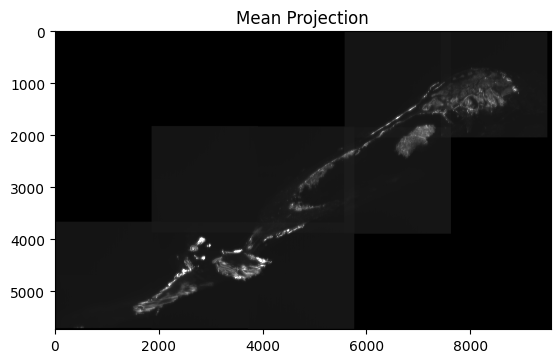

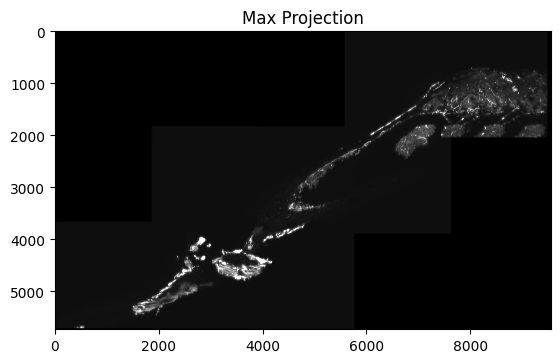

In [30]:

# Show projections
plt.figure()
plt.imshow(np.squeeze(mean_proj), cmap='gray', vmin=0, vmax=1000.)
plt.title("Mean Projection")

plt.figure()
plt.imshow(np.squeeze(max_proj), cmap='gray', vmin=0, vmax=2000.)
plt.title("Max Projection")

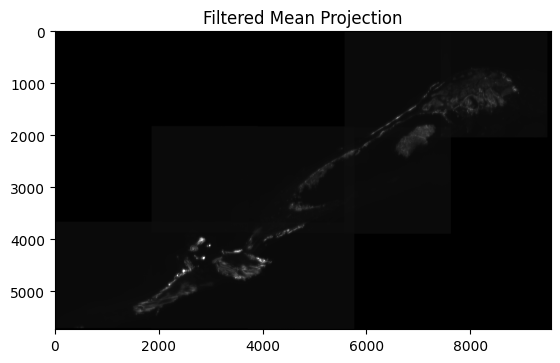

In [55]:
# Gaussian filtering using map_overlap
img_float = img.astype(np.float32)

sigma = 5.0

filtered = img_float.map_overlap(
    lambda x: gaussian(x, sigma=sigma, preserve_range=True),
    depth=int(2 * sigma),
    boundary='reflect'
)

# Projection of filtered image
filtered_proj = filtered.mean(axis=0).compute()

# plotting
plt.imshow(filtered_proj, cmap='gray', vmin=0, vmax=2000.)
plt.title("Filtered Mean Projection")
plt.show()

In [46]:

# Global Otsu threshold (must load full image into memory)
threshold = threshold_otsu(img[img > 0].compute())
print("Global Otsu Threshold:", threshold)

Global Otsu Threshold: 641


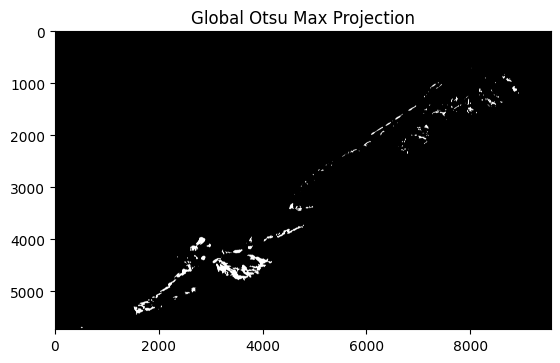

In [56]:
# Global thresholding function
def do_thresholding(x : da, thresh=0.0):

    return (x > thresh).astype(da.uint16)

# map_blocks or map_overlap doesn't matter here
# thresholded = img.map_blocks(do_thresholding, thresh=threshold)
thresholded = filtered.map_blocks(do_thresholding, thresh=threshold)

# Compute projection
thresholded_max = thresholded.max(axis=0).compute()

# plotting
plt.imshow(thresholded_max, cmap='gray', vmin=0, vmax=1)
plt.title("Global Otsu Max Projection")
plt.show()

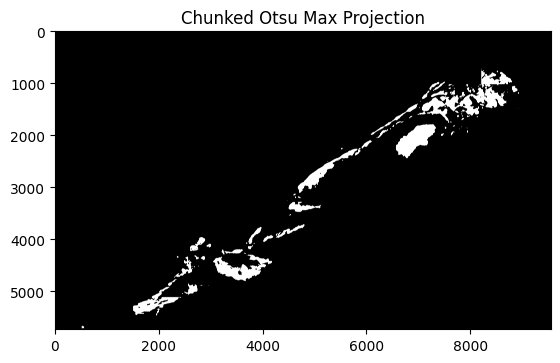

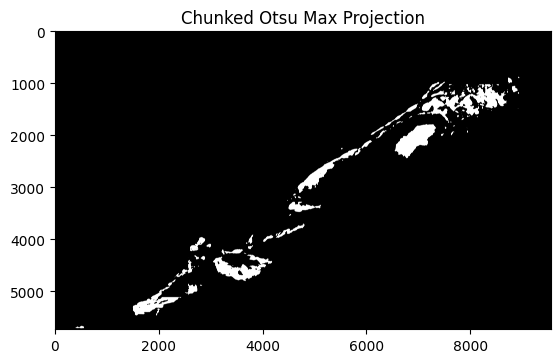

In [65]:
# What if we do per-chunk thresholding?

def per_chunk_otsu(x, flr=0.):

    th = threshold_otsu(x)

    if th > flr:
        return (x > th).astype(da.uint16)
    else:
        return da.zeros_like(x, dtype=da.uint16)

# apply to block chunks
otsu_blocks = filtered.map_blocks(per_chunk_otsu, flr=200.)
otsu_blocks_proj = otsu_blocks.max(axis=0).compute()

# apply to overlapping chunks
otsu_overlap = filtered.map_overlap(
    per_chunk_otsu,
    flr=200.,
    depth=(4,32,32),
    boundary='reflect'    
)

otsu_overlap_proj = otsu_overlap.max(axis=0).compute()

# plotting (Otsu blocks)
plt.imshow(otsu_blocks_proj, cmap='gray', vmin=0, vmax=1)
plt.title("Chunked Otsu Max Projection")
plt.show()

# plotting (Otsu overlap)
plt.imshow(otsu_overlap_proj, cmap='gray', vmin=0, vmax=1)
plt.title("Chunked Otsu Max Projection")
plt.show()